# Libraries

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import random
import time
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from scipy.optimize import minimize

import lightgbm as lgb
#import xgboost as xgb
#import catboost as ctb
#from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'loss'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 17
    CVSEED = 17
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 10000
    EARLY_STOPPING_ROUNDS = 200
    VERBOSE = 1000
    SEED = 17
    CVSEED = 17
    #N_ITERS = 10

In [3]:
def set_seed(seed=17):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-aug-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")


In [5]:
train['lgb_pred'] = np.load("../input/tps-aug-2021-lgb-no-pseudo/lgb_oof.npy")
test['lgb_pred'] = np.load("../input/tps-aug-2021-lgb-no-pseudo/lgb_pred.npy")/10

train['xgb_pred'] = np.load("../input/tps-aug-2021-xgb-no-pseudo-pred/3xgb_oof.npy")+np.load("../input/tps-aug-2021-xgb-no-pseudo-pred/4xgb_oof.npy")
test['xgb_pred'] = (np.load("../input/tps-aug-2021-xgb-no-pseudo-pred/3xgb_pred.npy")+np.load("../input/tps-aug-2021-xgb-no-pseudo-pred/4xgb_pred.npy"))/10

train['ctb_pred'] = np.load("../input/tps-aug-catb-no-pseudo/2ctb_oof.npy")+np.load("../input/tps-aug-catb-no-pseudo/3ctb_oof.npy")
test['ctb_pred'] = (np.load("../input/tps-aug-catb-no-pseudo/2ctb_pred.npy")+np.load("../input/tps-aug-catb-no-pseudo/3ctb_pred.npy"))/10

In [6]:
test.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f93,f94,f95,f96,f97,f98,f99,lgb_pred,xgb_pred,ctb_pred
0,250000,0.812665,15,-1.239120,-0.893251,295.5770,15.87120,23.04360,0.942256,29.898000,...,1.69075,1.059300,-3.010570,1.94664,0.529470,1.386950,8.78767,8.120738,7.732295,8.092161
1,250001,0.190344,131,-0.501361,0.801921,64.8866,3.09703,344.80500,0.807194,38.421900,...,1.84351,0.251895,4.440570,1.90309,0.248534,0.863881,11.79390,4.629908,4.877947,4.447047
2,250002,0.919671,19,-0.057382,0.901419,11961.2000,16.39650,273.24000,-0.003300,37.940000,...,1.55100,-0.559157,17.838600,1.83385,0.931796,2.336870,9.05400,8.572120,8.540636,8.321396
3,250003,0.860985,19,-0.549509,0.471799,7501.6000,2.80698,71.08170,0.792136,0.395235,...,1.41390,0.329272,0.802437,2.23251,0.893348,1.359470,4.84833,7.496467,7.472929,7.393689
4,250004,0.313229,89,0.588509,0.167705,2931.2600,4.34986,1.57187,1.118300,7.754630,...,1.58020,-0.191021,26.253000,2.68238,0.361923,1.532800,3.70660,7.207754,6.996287,7.297740


# Preprocessing

In [7]:
scale_features = [col for col in test.columns if 'f' in col]

ss = StandardScaler()
train[scale_features] = ss.fit_transform(train[scale_features])
test[scale_features] = ss.transform(test[scale_features])


In [8]:
# Swap noise

# Random
def apply_noise_rn(df, p=.75):
    should_not_swap = np.random.binomial(1, p, df.shape)
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Row-wise
def apply_noise_row(df, p=.75):
    should_not_swap = np.zeros(df.shape)
    for i in range(df.shape[0]):
        for j in np.random.choice(df.shape[1],int(p*df.shape[1]),replace=False):
            should_not_swap[i,j]=1 
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df
    

In [9]:
useful_features = scale_features + ['lgb_pred', 'xgb_pred','ctb_pred']

# LGB

In [10]:
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': N_ESTIMATORS,
    'n_jobs':-1,
    'importance_type': 'gain',
    #'device': 'gpu',
    #'gpu_platform_id': 0,
    #'gpu_device_id': 0,
        
    'learning_rate': 0.02353337642138889,
     'subsample': 0.8927518164857942,
     'colsample_bytree': 0.6082521012761244,
     'subsample_freq': 8,
     'reg_lambda': 30.353719041677138,
     'reg_alpha': 51.51192793124132,
     'min_child_weight': 191.56782210566885,
     'min_child_samples': 237
}


In [11]:
lgb_oof = np.zeros(train.shape[0])
lgb_pred = np.zeros(test.shape[0])
lgb_importances = pd.DataFrame()


kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED, SEED+1, SEED+2]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[useful_features], y=train[target])):
    print(f"===== fold {fold} =====")
    
    X_train, y_train = train[useful_features].iloc[trn_idx], train[target].iloc[trn_idx]
    #X_train = apply_noise_row(X_train)
    
    X_valid, y_valid = train[useful_features].iloc[val_idx], train[target].iloc[val_idx]
    X_test = test[useful_features]
    
    # LGB
    start = time.time()
    
    for inseed in seed_list:
        lgb_params['random_state'] = inseed
    
        pre_model = lgb.LGBMRegressor(**lgb_params)
        pre_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='rmse',
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            verbose=VERBOSE,
        )

        lgb_params2 = lgb_params.copy()
        lgb_params2['reg_lambda'] *= 0.9
        lgb_params2['reg_alpha'] *= 0.9
        lgb_params2['learning_rate'] *= 0.1
        model = lgb.LGBMRegressor(**lgb_params2)
        model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='rmse',
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
                init_model=pre_model
        )    

        with open(f"lgb_model{fold}.pkl", 'wb') as f:
            pickle.dump(model, f)

        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = model.feature_name_
        fi_tmp['importance'] = model.feature_importances_
        fi_tmp['fold'] = fold
        fi_tmp['seed'] = inseed
        lgb_importances = lgb_importances.append(fi_tmp)

        lgb_oof[val_idx] += model.predict(X_valid) / len(seed_list)
        lgb_pred += model.predict(X_test) / len(seed_list)
    
    elapsed = time.time() - start
    rmse = mean_squared_error(y_valid, lgb_oof[val_idx], squared=False)
    print(f"fold {fold} - lgb rmse: {rmse:.6f}, elapsed time: {elapsed:.2f}sec\n")

lgb_pred /= N_SPLITS
print(f"oof lgb_rmse = {mean_squared_error(train[target], lgb_oof, squared=False)}")

np.save("lgb_oof.npy", lgb_oof)
np.save("lgb_pred.npy", lgb_pred)


===== fold 0 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[150]	valid_0's rmse: 7.7382
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[151]	valid_0's rmse: 7.7382
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[188]	valid_0's rmse: 7.7385
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[189]	valid_0's rmse: 7.7385
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[125]	valid_0's rmse: 7.73914
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[229]	valid_0's rmse: 7.739
fold 0 - lgb rmse: 7.738141, elapsed time: 82.10sec

===== fold 1 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[184]	valid_0's rmse: 7.76435
Training until validation 

In [12]:
lgb_pred

array([8.20998293, 4.63302157, 8.79101511, ..., 5.93822322, 5.2954131 ,
       6.7470579 ])

# OOF predictions

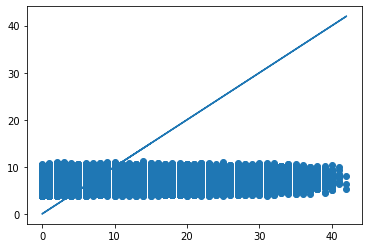

In [13]:
plt.plot(train[target], train[target])
plt.scatter(train[target], lgb_oof)

# Features importances

Text(0.5, 1.0, 'LightGBM feature importances')

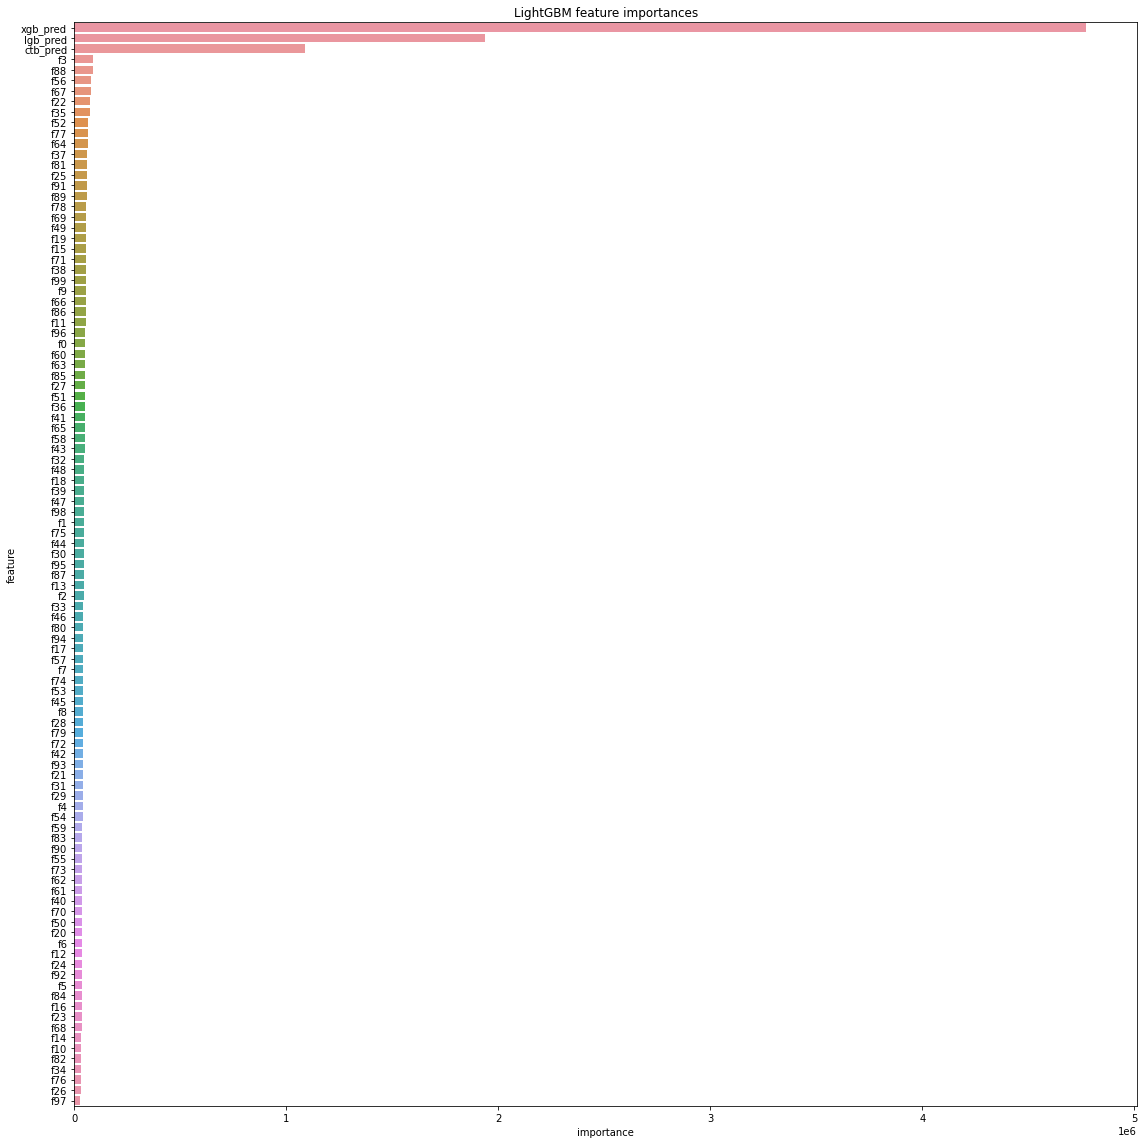

In [14]:
order = list(lgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=lgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LightGBM feature importances")

# Submission

In [15]:
submission[target] = lgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,loss
0,250000,8.209983
1,250001,4.633022
2,250002,8.791015
3,250003,7.676684
4,250004,7.163667
...,...,...
149995,399995,7.746504
149996,399996,7.578610
149997,399997,5.938223
149998,399998,5.295413
